Roll no 20EC390022, 20EC39054

In [267]:
import math
from struct import pack
from bitarray import bitarray
import numpy as np
import cv2

In [268]:
N = 8 #block size

In [269]:
# image padding to get 8x8 block
def pad_img(r, g, b):
   h, w = np.shape(r)
   new_H, new_W = ((h+7)//8)*8, ((w+7)//8)*8
   new_r = np.zeros((new_H, new_W))
   new_g = np.zeros((new_H, new_W))
   new_b = np.zeros((new_H, new_W))
   new_r[0:h, 0:w], new_g[0:h, 0:w], new_b[0:h, 0:w] = r, g, b
   return new_r, new_g, new_b

In [270]:
# converting RGB to YCbCr
def RGB_TO_YCBCR(r,g,b):
  y = 0.299*r[0:N,0:N]+0.587*g[0:N,0:N]+0.114*b[0:N,0:N]
  cb = -0.169*r[0:N,0:N]-0.331*g[0:N,0:N]+0.5*b[0:N,0:N]
  cr = 0.5*r[0:N,0:N]-0.419*g[0:N,0:N]-0.081*b[0:N,0:N]
  return y,cb,cr

In [271]:
# Fuction for DCT calcualtion
def DCT(a):
    n = len(a)
    if n == 1:
        return list(a)
    else:
        half = n // 2
        alpha = [(a[i] + a[-(i + 1)]) for i in range(half)]
        beta  = [(a[i] - a[-(i + 1)]) / (math.cos((i + 0.5) * math.pi / n) * 2.0) for i in range(half)]
        alpha = DCT(alpha)
        beta  = DCT(beta )
        result = []
        for i in range(half - 1):
            result.append(alpha[i])
            result.append(beta[i] + beta[i + 1])
        result.append(alpha[-1])
        result.append(beta [-1])
        return result

def DCT2(a):
    A = [[0 for _ in range(N)] for __ in range(N)]

    scaling = math.sqrt(2/N)
    for col in range(N):
        cur = []
        for row in range(N):
            cur.append(a[row][col])
        cur = DCT(cur)
        for row in range(N):
            A[row][col]=cur[row]*scaling
            if row==0:
                A[row][col]/=math.sqrt(2)

    for row in range(N):
        cur = []
        for col in range(N):
            cur.append(A[row][col])
        cur = DCT(cur)
        for col in range(N):
            A[row][col]=cur[col]*scaling
            if col==0:
                A[row][col]/=math.sqrt(2)
    return A



In [272]:
# function for normalizing cofficients
def norm_coeff(n):
        if n == 0:
            return 1.0 / math.sqrt(2.0)
        else:
            return 1.0

# function for quantiztion
def Quantize(a, q):
    b = [[0 for _ in range(N)] for __ in range(N)]
    for row in range(N):
        for col in range(N):
            b[row][col] = round(a[row][col]/q[row][col])
    return b

# function for getting zigzag order
def Zigzag_Order(b):
    ind=0
    down=False
    z = [0 for _ in range(N*N)]
    for sum in range(2*N-1):
        row, col = None,None;
        if down:
            row = 0
            col = sum-row;
            if col>=N:
                col = N-1
                row = sum-col;
        else:
            col = 0
            row = sum-col;
            if row>=N:
                row = N-1
                col = sum-row;

        while row>=0 and row<N and col>=0 and col<N:
            z[ind]=b[row][col]
            ind += 1
            if down:
                row+=1
                col-=1
            else:
                row-=1
                col+=1
        down = ~(down);
    return z

In [273]:
# function for run length encoding
def Run_Length_Encode(z):
    l,r = 1, 1
    lst = N*N-1
    rle = []
    while lst>=0 and z[lst]==0:
        lst -= 1
    while r<=lst:
        if (z[r]==0 and r-l+1==16) or z[r]!=0:
            rle += [r-l, int(z[r]).bit_length(), z[r]]
            l=r+1
        r += 1
    if lst!=N*N-1:
        rle += [0,0]
    return rle

In [274]:
# function to get huffman coding
def huffcode(code_dict,node,code):

    if(node[1][1]==None and node[1][2]==None):
        code_dict[node[1][0]]=code
        return

    if(node[1][1]!=None):
        code_nxt=code+"0"
        huffcode(code_dict,node[1][1],code_nxt)

    if(node[1][2]!=None):
        code_nxt=code+"1"
        huffcode(code_dict,node[1][2],code_nxt)

def modify_huffcode(code_dict):
    new_code_dict = dict()
    vals_list = [[] for _ in range(17)]
    for (key,val) in code_dict.items():
        vals_list[len(val)].append(key)

    cur = 0
    for i in range(17):
        for j in range(len(vals_list[i])):
            cur_bin = bin(cur)[2:]
            if '0'*(i-len(cur_bin))+cur_bin=='1'*i:
                vals_list[i+1] = [vals_list[i][j]]+vals_list[i+1]
                continue
            new_code_dict[vals_list[i][j]]='0'*(i-len(cur_bin))+cur_bin
            cur+=1
        cur<<=1
    return new_code_dict

def Huffcode_Gen(x):
    freq=dict()
    for i in range(len(x)):
        if x[i] in freq:
            freq[x[i]]+=1
        else:
            freq[x[i]]=1

    pq=list()
    for ele in freq:
        pq.append([freq[ele],[ele,None,None]])

    pq.sort()
    while(len(pq)>1):
        t1=pq[0]
        t2=pq[1]

        curr=[t1[0]+t2[0],[-1,t1,t2]]
        pq.remove(t1)
        pq.remove(t2)
        pq.append(curr)
        pq.sort(key = lambda t:t[0])

    huffTree=pq[0]

    code_dict=dict()
    code=""
    huffcode(code_dict,huffTree,code)
    code_dict=modify_huffcode(code_dict)
    return code_dict

In [275]:
# writing quantization table in output jpg file
def write_quant_table(JPEG_out, quant_table, type):
    JPEG_out.write(b'\xff\xdb') # marker
    JPEG_out.write(pack(">H",67)) # length of chunk
    JPEG_out.write(pack("B",type))
    zigzag_quant = Zigzag_Order(quant_table)
    for i in range(N*N):
        JPEG_out.write(pack("B",zigzag_quant[i]))

In [276]:
# writing JPEG Start Of Frame segment tags in jpg file
def write_SOF(JPEG_out,height,width,components):
    JPEG_out.write(b'\xff\xc0') # marker
    JPEG_out.write(pack(">H",8+3*components)) # length of chunk
    JPEG_out.write(pack("B",8)) # bits/sample
    JPEG_out.write(pack(">HHB",height,width,components)) # height,width,components of image

    for i in range(components):
        #id, sampling factor, quant table id
        JPEG_out.write(pack("BBB", i+1, 16+1, min(i,1)))


In [277]:
# writing huffman table in jpg file
def write_huffman_table(JPEG_out,type,code):
    JPEG_out.write(b'\xff\xc4') # marker
    JPEG_out.write(pack(">HB",19+len(code),type))

    val_list = [[] for _ in range(16)]
    for (key,val) in code.items():
        val_list[len(val)-1].append(key)

    for i in range(16):
        JPEG_out.write(pack("B",len(val_list[i])))
    for i in range(16):
        for val in val_list[i]:
            JPEG_out.write(pack("B",val))


In [278]:
def add_FF00(data):
    result = ""
    for i in range(0,len(data),8):
        cur_byte = data[i:i+8]
        result = result+cur_byte
        if cur_byte=="11111111":
            result = result+"00000000"
    return result

In [279]:
def write_SOS(JPEG_out,components,Y_dc_list, CB_dc_list, CR_dc_list, Y_ac_list, CB_ac_list, CR_ac_list,Y_dc_vli_list, CB_dc_vli_list, CR_dc_vli_list, Y_ac_vli_list, CB_ac_vli_list, CR_ac_vli_list,lum_dc_code,lum_ac_code,chr_dc_code,chr_ac_code):
    JPEG_out.write(b'\xff\xda')
    JPEG_out.write(pack(">HB",6+2*components,components))
    JPEG_out.write(b'\x01\x00\x02\x11\x03\x11')
    JPEG_out.write(pack("BBB",0,63,0))
    Y_dc_ptr, CB_dc_ptr, CR_dc_ptr, Y_ac_ptr, CB_ac_ptr, CR_ac_ptr,Y_dc_vli_ptr, CB_dc_vli_ptr, CR_dc_vli_ptr, Y_ac_vli_ptr, CB_ac_vli_ptr, CR_ac_vli_ptr = 0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0
    data = ""
    while Y_dc_ptr<len(Y_dc_list):
        data = data+lum_dc_code[Y_dc_list[Y_dc_ptr]]+Y_dc_vli_list[Y_dc_vli_ptr]
        Y_dc_ptr+=1
        Y_dc_vli_ptr+=1
        length_block = 1
        while length_block<N*N and Y_ac_list[Y_ac_ptr]!=0:
            data = data+lum_ac_code[Y_ac_list[Y_ac_ptr]]+Y_ac_vli_list[Y_ac_vli_ptr]

            length_block += (Y_ac_list[Y_ac_ptr]>>4)
            length_block += 1
            Y_ac_ptr+=1
            Y_ac_vli_ptr+=1
        if length_block<N*N:
            data = data+lum_ac_code[0]
            Y_ac_ptr+=1

        data = data+chr_dc_code[CB_dc_list[CB_dc_ptr]]+CB_dc_vli_list[CB_dc_vli_ptr]
        CB_dc_ptr+=1
        CB_dc_vli_ptr+=1
        length_block = 1
        while length_block<N*N and CB_ac_list[CB_ac_ptr]!=0:
            data = data+chr_ac_code[CB_ac_list[CB_ac_ptr]]+CB_ac_vli_list[CB_ac_vli_ptr]
            length_block += (CB_ac_list[CB_ac_ptr]>>4)
            length_block += 1
            CB_ac_ptr+=1
            CB_ac_vli_ptr+=1
        if length_block<N*N:
            data = data+chr_ac_code[0]
            CB_ac_ptr+=1

        data = data+chr_dc_code[CR_dc_list[CR_dc_ptr]]+CR_dc_vli_list[CR_dc_vli_ptr]
        CR_dc_ptr+=1
        CR_dc_vli_ptr+=1
        length_block = 1
        while length_block<N*N and CR_ac_list[CR_ac_ptr]!=0:
            data = data+chr_ac_code[CR_ac_list[CR_ac_ptr]]+CR_ac_vli_list[CR_ac_vli_ptr]
            length_block += (CR_ac_list[CR_ac_ptr]>>4)
            length_block += 1
            CR_ac_ptr+=1
            CR_ac_vli_ptr+=1
        if length_block<N*N:
            data = data+chr_ac_code[0]
            CR_ac_ptr+=1

    while len(data)%8!=0:
        data=data+"0"
    data = add_FF00(data)
    data=bitarray(data)
    JPEG_out.write(data)


In [280]:
def get_vli(x):
    if x==0:
        return ''
    if x<0:
        x=-x
        ans = bin((~x)&((1<<int(x).bit_length())-1))[2:]
        ans = "0"*(len(bin(x))-2-len(ans))+ans
    else:
        ans=bin(x)[2:]
    return ans

In [281]:
def RLE_To_Bits(rle):
    rl_class,vli = [],[]
    for i in range(0,len(rle),3):
        rl_class.append(((rle[i]<<4)+rle[i+1]))
        if rl_class[-1]==0:
            break
        vli.append(get_vli(rle[i+2]))
    return rl_class,vli

In [282]:
def JPEG_encoder(r,g,b):
    '''
        applies jpeg compression on image and ouputs the compressed image in jpg format
    '''
    r,g,b = pad_img(r,g,b)
    height,width = r.shape
    quant_lum = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])
    quant_chr = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])
    Y_dc_vli_list,CB_dc_vli_list,CR_dc_vli_list,Y_ac_vli_list,CB_ac_vli_list,CR_ac_vli_list = [],[],[],[],[],[]
    Y_dc_list, CB_dc_list, CR_dc_list, Y_ac_list, CB_ac_list, CR_ac_list = [],[],[],[],[],[]

    scale = float(input("Enter the scaling for standard quantization table:"))
    quant_lum = [[min(max(1,int(quant_lum[i][j]*scale)),255) for j in range(N)] for i in range(N)]
    quant_chr = [[min(max(1,int(quant_chr[i][j]*scale)),255) for j in range(N)] for i in range(N)]


    prev_Y_dc,prev_CB_dc,prev_CR_dc = 0,0,0
    for i in range(len(r)//8):
        for j in range(len(r[0])//8):

            cur_r = r[i*N:(i+1)*N,j*N:(j+1)*N] - 128
            cur_g = g[i*N:(i+1)*N,j*N:(j+1)*N] - 128
            cur_b = b[i*N:(i+1)*N,j*N:(j+1)*N] - 128

            y,cb,cr = RGB_TO_YCBCR(cur_r,cur_g,cur_b)
            Y,CB,CR = DCT2(y),DCT2(cb),DCT2(cr)

            Y,CB,CR = Quantize(Y,quant_lum),Quantize(CB,quant_chr),Quantize(CR,quant_chr)
            Y_z,CB_z,CR_z = Zigzag_Order(Y),Zigzag_Order(CB),Zigzag_Order(CR)

            Y_rle,CB_rle,CR_rle = Run_Length_Encode(Y_z),Run_Length_Encode(CB_z),Run_Length_Encode(CR_z)
            Y_rl_class, Y_vli = RLE_To_Bits(Y_rle)
            CB_rl_class, CB_vli = RLE_To_Bits(CB_rle)
            CR_rl_class, CR_vli = RLE_To_Bits(CR_rle)

            Y_ac_list = Y_ac_list+Y_rl_class
            CB_ac_list = CB_ac_list+CB_rl_class
            CR_ac_list = CR_ac_list+CR_rl_class

            Y_ac_vli_list = Y_ac_vli_list+Y_vli
            CB_ac_vli_list = CB_ac_vli_list+CB_vli
            CR_ac_vli_list = CR_ac_vli_list+CR_vli

            Y_dc,CB_dc,CR_dc = Y_z[0]-prev_Y_dc, CB_z[0]-prev_CB_dc, CR_z[0]-prev_CR_dc
            Y_dc_list.append(int(Y_dc).bit_length())
            CB_dc_list.append(int(CB_dc).bit_length())
            CR_dc_list.append(int(CR_dc).bit_length())

            Y_dc_vli_list.append(get_vli(Y_dc))
            CB_dc_vli_list.append(get_vli(CB_dc))
            CR_dc_vli_list.append(get_vli(CR_dc))

            prev_Y_dc,prev_CB_dc,prev_CR_dc = Y_z[0],CB_z[0],CR_z[0]

    lum_dc_code = Huffcode_Gen(Y_dc_list)
    lum_ac_code = Huffcode_Gen(Y_ac_list)
    chr_dc_code = Huffcode_Gen(CB_dc_list+CR_dc_list)
    chr_ac_code = Huffcode_Gen(CB_ac_list+CR_ac_list)

    output_file = input("Enter output file name without extension: ")
    JPEG_out = open(output_file+".jpg", "wb")
    JPEG_out.write(b'\xff\xd8\xff\xe0')
    JPEG_out.write(pack(">H",16))
    JPEG_out.write(b'JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00')


    write_quant_table(JPEG_out, quant_lum, 0)
    write_quant_table(JPEG_out, quant_chr, 1)

    write_SOF(JPEG_out,height,width,3)

    write_huffman_table(JPEG_out,0,lum_dc_code)
    write_huffman_table(JPEG_out,16,lum_ac_code)
    write_huffman_table(JPEG_out,1,chr_dc_code)
    write_huffman_table(JPEG_out,17,chr_ac_code)

    write_SOS(JPEG_out,3,Y_dc_list, CB_dc_list, CR_dc_list, Y_ac_list, CB_ac_list, CR_ac_list,Y_dc_vli_list, CB_dc_vli_list, CR_dc_vli_list, Y_ac_vli_list, CB_ac_vli_list, CR_ac_vli_list,lum_dc_code,lum_ac_code,chr_dc_code,chr_ac_code)

    JPEG_out.write(b'\xff\xd9')
    JPEG_out.close()


In [283]:
from google.colab.patches import cv2_imshow

Enter the input image file name for jpeg compression: lena.bmp
Enter the scaling for standard quantization table:10
Enter output file name without extension: out


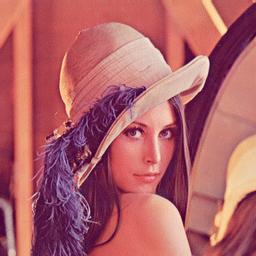

In [284]:
#input block
input_path = input("Enter the input image file name for jpeg compression: ")
img = cv2.imread(input_path)
r = img[:,:,2]
g = img[:,:,1]
b = img[:,:,0]

JPEG_encoder(r,g,b)
cv2_imshow(img)


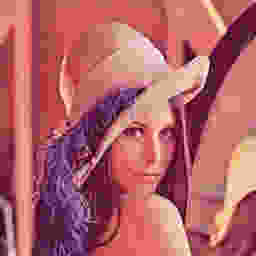

In [286]:
img = cv2.imread("out.jpg", cv2.IMREAD_UNCHANGED)
cv2_imshow(img)